In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D
plt.style.use('dark_background')


Using TensorFlow backend.


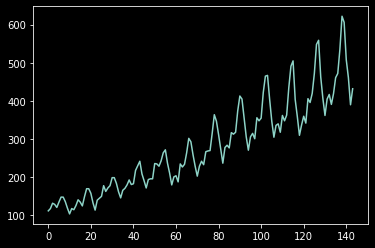

In [2]:
df = read_csv('data/AirPassengers.csv', usecols=[1])
plt.plot(df)


In [3]:
dataset = df.values
dataset = dataset.astype('float32')

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]




In [6]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)


In [7]:
seq_size = 10
#can be larger for larger datasets, number of previous values the forecast is predicted using

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [8]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (89, 10)
Shape of test set: (33, 10)


In [9]:
trainX = trainX.reshape((trainX.shape[0], 1,seq_size))
testX = testX.reshape((testX.shape[0], 1, seq_size))

In [10]:
print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()

Single LSTM with hidden Dense...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Train on 89 samples, validate on 33 samples
Epoch 1/100
 - 4s - loss: 0.0778 - val_loss: 0.3356
Epoch 2/100
 - 0s - loss: 0.0449 - val_loss: 0.2074
Epoch 3/100
 - 0s - loss: 0.0231 - val_loss: 0.1141
Epoch 4/100
 - 0s - loss: 0.0116 - val_loss: 0.0562
Epoch 5/100
 - 0s - loss: 0.0080 - val_loss: 0.0313
Epoch 6/100
 - 0s - loss: 0.0101 - val_loss: 0.0259
Epoch 7/100
 - 0s - loss: 0.0123 - val_loss: 0.0255
Epoch 8/100
 - 0s - loss: 0.0115 - val_loss: 0.0262
Epoch 9/100
 - 0s - loss: 0.0091 - val_loss: 0.0306
Epoch 10/100
 - 0s - loss: 0.0073 - val_loss: 0.0386
Epoch 11/100
 - 0s - loss: 0.0066 - val_loss: 0.0468
Epoch 12/100
 - 0s - loss: 0.0067 - val_loss: 0.0511
Epoch 13/100
 - 0s - loss: 0.0070 - val_loss: 0.0509
Epoch 14/100
 - 0s - loss: 0.0068 - val_loss: 0.0463
Epoch 15/100
 - 0s - loss: 0.0064 - val_loss: 0.0395
Epoch 16/100
 - 0s - loss: 0.0059 - val_loss: 0.0332
Epoch 17/100
 - 0s - loss: 0.0056 - val_loss: 0.0288
Epoch 18/100
 - 0s - loss: 0.0055 - val_loss: 0.0262
Epoch 19/10

In [12]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [13]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [14]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 20.49 RMSE


In [15]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Test Score: 47.66 RMSE


In [16]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


In [17]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

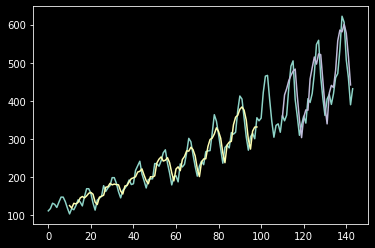

In [18]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [19]:
dataset_resid = scaler.inverse_transform(dataset)


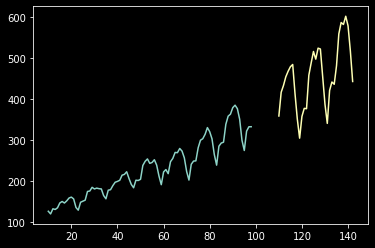

In [20]:
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [21]:
l = [trainPredictPlot,testPredictPlot]

In [22]:
predicted_train = []
predicted_test = []
for v in trainPredictPlot:
    if math.isnan(v[0]):
        predicted_train.append(0)
    else:
        predicted_train.append(v[0])
predicted_test = []
for v in testPredictPlot:
    if math.isnan(v[0]):
        predicted_test.append(0)
    else:
        predicted_test.append(v[0])
    
        

In [23]:
predicted_train = np.array(predicted_train)
predicted_test = np.array(predicted_test)

In [24]:
predicted_final = predicted_test+predicted_train

In [25]:
dataset_resid = np.array([i[0] for i in dataset_resid])

In [35]:
residual = dataset_resid - predicted_final
residual_df = pd.DataFrame(residual)

In [36]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(residual_df)
if pvalue > 0.05:
    print('the data is not stationary')
else:
    print('the data is stationary')

the data is not stationary


In [39]:
from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(residual_df[0], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)           
  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1517.100, Time=1.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1517.644, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1495.828, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1478.874, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1515.119, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1480.858, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1480.853, Time=0.84 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1495.711, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1482.697, Time=2.69 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1478.116, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1479.946, Time=0.47 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1479.893, Time=0.94 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1494.686, Time=0.17 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(1,1,0)(0,1,1)[12]

In [42]:
print(arima_model.summary() )

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -737.058
Date:                              Sat, 29 May 2021   AIC                           1478.116
Time:                                      20:38:46   BIC                           1483.867
Sample:                                           0   HQIC                          1480.453
                                              - 144                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.7468      0.062    -12.137      0.000      -0.867      -0.626
sigma2      4191.64

In [43]:
size = int(len(residual_df) * 2/3)
X_train, X_test = residual_df[0:size], residual_df[size:len(df)]

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train[0],  
                order = (0, 1, 0),  
                seasonal_order =(0, 1, 1, 12)) 

In [45]:
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   96
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -368.885
Date:                              Sat, 29 May 2021   AIC                            741.770
Time:                                      20:41:32   BIC                            746.607
Sample:                                           0   HQIC                           743.713
                                               - 96                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.3383      0.085     -3.971      0.000      -0.505      -0.171
sigma2       417.1728     27.668     15.078      0.000     362.944     471.402
===================================================================================
Ljung-Box (L1) (Q):                   2.60   Jarque-Bera (JB):              1501.14
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             3.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

In [56]:
start_index = len(X_train)
end_index = len(df)-1
test_prediction = result.predict(start_index, end_index).rename('Predicted') 

<AxesSubplot:>

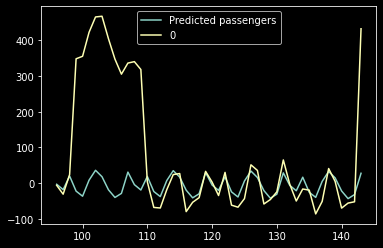

In [57]:
prediction.plot(legend = True) 
X_test[0].plot(legend = True) 

In [49]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train[0], train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test[0], prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 28.10 RMSE
Test Score: 193.74 RMSE


In [50]:
forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 

In [63]:
residual_prediction = [v for v in train_prediction]

In [65]:
for v in test_prediction:
    residual_prediction.append(v)

In [69]:
hybrid_prediction = predicted_final + np.array(residual_prediction)

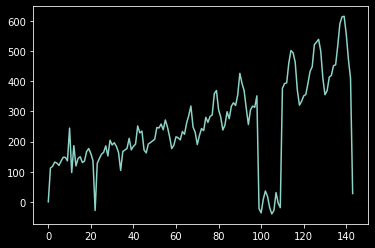

In [70]:
plt.plot(hybrid_prediction)

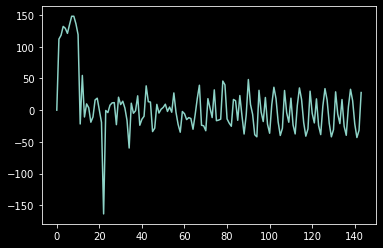

In [71]:
plt.plot(residual_prediction)